# Plotting expression data
## of given gene ID's
01. This script plot the expression data of defined gene modules from WGCNA
The modules are named by colors (e.g. red, blue, ect.). This script allow the input of a colorname and plots the expressin values of all the genes in that module.
02. This script plot the expression data of any given list of gene ID's. 
This script allows the input of gene list (robin IDs or ncbi ID) and will plot the expression value of the given genes.

## Instalation
This script uses seaborn 0.11, which has to be installed on your computer. The older version 0.10 is not compatible with this script. You can install seaborn with the following code. Then you check which version you just or already have installed, and upgrade if nessecary. If you need to upgrade, you will have to restart your device or source it in the command line.

In [ ]:
# install seaborn
conda install seaborn
# check if the installed version is 0.11.2
sns.__version__
# update if nessecary
!pip install seaborn --upgrade

### Housekeeping
You start with specifing the path to your machine, and the species you want to investigate. These 
Next you import all the modules used for this script

In [31]:
### Housekeeping
# 
# load modules
import sqlite3 # to connect to database
import pandas as pd # data anaylis handeling
import numpy as np  
import matplotlib.pyplot as plt #plotting
import seaborn as sns # plotting
import colorsys # color palette
import matplotlib # plotting
import scipy.stats as stats # z-score transformation
from matplotlib.backends.backend_pdf import PdfPages # Saving as pdf
#
# specify path to folder were your data files are, or your database is
path = '/Users/roos_brouns/Dropbox/Ant-fungus/02_scripts/Git_Das_folder2/Das_et_al_2022a'


### Ad definitions
#
# Add defenition for color palette making for plotting. 
# source: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

# Add defenition for background shading
# source: https://stackoverflow.com/questions/54652114/matplotlib-how-can-i-add-an-alternating-background-color-when-i-have-dates-on-t
class GridShader():
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))
        
        # Original from source, makes alternating shadow grids 
#         start = locs[1-int(self.sf)::2]  
#         end = locs[2-int(self.sf)::2]
#         for s, e in zip(start, end):
#             self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))
       
        # Altered for own pupose
        #
        # start shading for Day from 1st
        start_D = locs[0:5]
        # end shading at 6th grid
        end_D = locs[6:7]
        #
        # Give the grids a gold color for the Day
        for s, e in zip(start_D, end_D):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, facecolor='gold', **self.kw))
        #
        
        
         # Start night shading at 7th grid
        start_P = locs[6:12]
        # end shading at 6th grid
        end_P = locs[7:13]
        
        for s, e in zip(start_P, end_P):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, facecolor='navy', **self.kw))
        
        # Start day shading again 
        start_N = locs[12:13]
        # end shading at 14th grid
        end_N = locs[13:15]
        
        # Give the grids a navy color for the Night
        for s, e in zip(start_N, end_N):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, facecolor='gold', **self.kw))
            
#         # Last grid gold again
#         self.spans.append(self.ax.axvspan(locs[14], locs[16], zorder=0, facecolor='navy', **self.kw))
        
                
            

### Load in the data
The next step is to load in the data. This can be done with connection to a database base in this example or a excel/cvs with the data kan be read in. The database used in this tutorial is can be made with another script <db_making> [REF].

In [2]:
# specify species
#
# for Ophiocordyceps camponoti-florani
# species = 'ophio_cflo'
# for Beauveria bassiana
species = 'beau'

In [3]:
### Load in data via Database
# 
# * exp_val must contain expression values per time-point per gene ID
# * data must contain all other info about the genes, e.g. all gene ID's, module identities, gammaP values ect.
#
# Connect to the database
conn = sqlite3.connect(f'{path}/data/databases/new_TC6_fungal_data.db')
#
# read data from DB into dataframe  
exp_val = pd.read_sql_query(f"SELECT * from {species}_fpkm", conn)

### Clean data
#
# drop 'start' and 'end' columns
exp_val.drop(['start','end'], axis=1, inplace=True)

### Load in Data via csv
#
# Load in the whole csv
data = pd.read_csv(f'{path}/data/{species}_TC6_data.csv')
# select the expression values
exp_val = data.drop(data.columns[14:len(data.columns)], axis=1)

### Part 01. Plotting expression value of modules
This next part of code plots the expression values of all the genes in a defined module. These module have been defined with WCGNA and <Billu's tutorial> can be used to do this step [REF]. 
* This code will ask for an input of color names of the defined module

In [75]:
### Preset input for modules ######
#
# plot  modules (M)
module_goal = 'M'

# Clusters for ophio and beau that have rhythmic genes in it
#
# ophio
input_string = 'tan midnightblue darkturquoise'
# beauveria
#input_string = 'red darkred salmon'

module_list = input_string.split()

In [26]:
### N. crassa clock genes ######
#
# plot  genes (G)
module_goal = 'G'
#
# N crassa orthologs in Ophio_cflo
# module_list= ['Ophcf2|06690','Ophcf2|01775','Ophcf2|02346','Ophcf2|01187','Ophcf2|05709','Ophcf2|02284','Ophcf2|03331','Ophcf2|01137']
# for Beauveria 
module_list = ['BBA_01528', 'BBA_10271', 'BBA_01403', 'BBA_02876', 'BBA_08737', 'BBA_00328', 'BBA_07925', 'BBA_02816']
ortho_names = ['frq','wc-1','wc-2','vvd','nik-2','dcc-1','luxQ','phy-1']

In [4]:
### Frequency genes in beauveria
#
# plot  genes (G)
module_goal = 'G'
#
module_list = ['BBA_01528', 'BBA_08957', 'BBA_02496']
ortho_names = ['frq1','frq2','frh']

In [4]:
### Conidiophore development genes in Beauveria
#
# plot  genes (G)
module_goal = 'G'
#
module_list = ['BBA_04941', 'BBA_07544', 'BBA_00300', 'BBA_06126']
ortho_names = ['fluG','brlA','abaA', 'wetA']

In [6]:
### CRY-Dash
#
# plot  genes (G)
module_goal = 'G'
gene_ID = 'gene_ID_ncbi'
#
# Ophio_cflo
# module_list = ['Ophcf2|06230'] # GQ602_006230
#
# Beau
module_list = ['BBA_02424']
ortho_names = ['cry-DASH']

In [5]:
##### Interactive input block ###########
#
# Ask input for module or genes
module_goal = input('Plot gene or module expression? Type in gene/G or module/M: ')
# give space separeted list of module colors or gene ID's
input_string = input('Enter elements of a list separated by space: ')

print("\n")
module_list = input_string.split()
# print list
print('given input: ', module_list)

Plot gene or module expression? Type in gene/G or module/M: m
Enter elements of a list separated by space: k


given input:  ['k']


In [5]:
### Set if you look want to search by Robin gene ID's or NCBI gene ID's
gene_ID = 'gene_ID_ncbi' 
# gene_ID = 'gene_ID_robin'

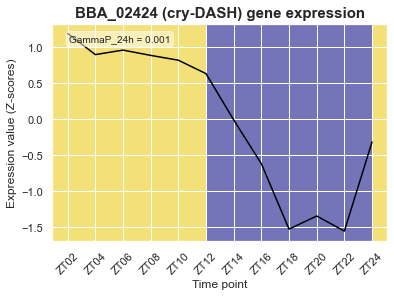

In [32]:
### Part 01. Plot expressioin value of modules
#
# A1. Get the data you want to plot
## --- moved to data load ----

try:
    
    for i in range(0,len(module_list)):
        
        # A2. Data selection for module or gene_ID
        #
        # Define the module you want to plot
        module_name = module_list[i]
        # select all the data of that module
        if module_goal == 'G' or module_goal == 'gene':
            module_data = data.loc[data[gene_ID] == module_name]
        elif module_goal == 'M' or module_goal == 'module': 
            module_data = data.loc[data['module_identity'] == module_name]
        else:
            print('specify G or M')
        # select the gene ID's in of the module
        module_IDs = pd.DataFrame(module_data[gene_ID])
        # get the expression values of the selected gene ID's in the module
        exp_val_module = module_IDs.merge(exp_val, on=gene_ID, how='left')
        

        # B. Data transformation
        #
        # Transform the dataframe so we can plot
        t_exp_val_module = exp_val_module.T
        t_exp_val_module.drop(['gene_ID_robin','gene_ID_ncbi'], axis=0, inplace=True)
        # 
        # Covert integer type of DF to float, which is nessacary to use transformation functions
        t_exp_val_module_float = t_exp_val_module.astype(float)
        # Log2 transformation
        tl_exp_val_module = np.log2(t_exp_val_module_float)
        # Z-score transformation
        tz_exp_val_module = t_exp_val_module_float.apply(stats.zscore)

        if module_goal == 'M' or module_goal == 'module':
            # C. Plotting colors aesthetics
            #
            # Make the color palette for plotting
            color = matplotlib.colors.ColorConverter.to_rgb(module_name)
            rgbs = [scale_lightness(color, scale) for scale in [0.3, .6, 1, 1.1, 1.25]]
            # Show the palette color
            # sns.palplot(rgbs)
            #
            # set background and the color palette
            sns.set_theme()
            sns.set_palette(rgbs)
        
            # D. Calcuate median of per time point of all gene expression values
            # 
            # for FPMK
            median_df_t = t_exp_val_module.median(axis=1)
            # for Log2 values
            median_df_tl = tl_exp_val_module.median(axis=1)
            # for z-scores
            median_df_tz = tz_exp_val_module.median(axis=1)
        else: 
            sns.set_theme()
        
        if module_goal == 'M' or module_goal == 'module':
            # E. Plotting the gene expression values against the time with median, without legend and with titles 
            #
            # Plot for FPKM
            ax1 = t_exp_val_module.plot(legend=False)
            median_df_t.plot(ax=ax1, color='red') # plot the median in black
            ax1.set_title(species[0].upper()+f'{species[1:len(species)]}-{module_name} gene expression', fontsize=15, fontweight='bold')
            ax1.set_xlabel('Time point')
            ax1.set_ylabel('Expression value (FPKM)')
            fig1 = ax1.get_figure()
            #
            # Plot for log2 values
            ax2 = tl_exp_val_module.plot(legend=False) # no legend
            median_df_tl.plot(ax=ax2, color='red') # plot the median in black
            ax2.set_title(species[0].upper()+f'{species[1:len(species)]}-{module_name} gene expression', fontsize=15, fontweight='bold') # plot title
            ax2.set_xlabel('Time point') # make xlabel
            ax2.set_ylabel('Expression value (Log2)') # make ylabel
            fig2 = ax2.get_figure()
            #
            # Plot for z-scores
            ax3 = tz_exp_val_module.plot(legend=False, color = 'red')
            median_df_tz.plot(ax=ax3, color='black') # plot the median in black
            # put ZT labels in variable
            ndx = t_exp_val_module.index
            # put all labels on x-axis with a rotation
            plt.xticks(range(len(ndx)), ndx, rotation=45)
            # Set title
            ax3.set_title(species[0].upper()+f'{species[1:len(species)]}-{module_name} gene expression', fontsize=15, fontweight='bold')
            # Set xlabel
            ax3.set_xlabel('Time point')
            # Set ylabel
            ax3.set_ylabel('Expression value (Z-scores)')
            # Shade the grids
            gs = GridShader(ax3, first=False, alpha=0.5)
            # Save ax in figure object
            fig3 = ax3.get_figure()

    #         # F. Save plot to pdf file
    #         # 
    #         # Path to where the pfd's are saved
    #         pp = PdfPages(f'{path}/results/figures/module_expression_plots/{species}_{module_name}_plot.pdf')
    #         #
    #         # Save the figures to the pfd
    #         pp.savefig(fig1)
    #         pp.savefig(fig2)
    #         pp.savefig(fig3)
    #         #
    #         pp.close()
            #
            ### Done.
        else:
            # Plot for FPKM or Z-scores (=tz_exp_val_module) of Log2Value (=tl_exp_val_module)
            ax = tz_exp_val_module.plot(legend=False, color = 'black')
            # put ZT labels in variable
            ndx = t_exp_val_module.index
            # put all labels on x-axis with a rotation
            plt.xticks(range(len(ndx)), ndx, rotation=45)
            
            # Ad gamma-P value in text box 
            #
            # Get the gammaP value 
            module_data.reset_index(inplace=True, drop=True)
            gamma_p = module_data.loc[0,'GammaP_24h'].round(3)
            # Ad text box
            # source: https://matplotlib.org/3.3.4/gallery/recipes/placing_text_boxes.html
            textstr= f'GammaP_24h = {gamma_p}'
            props = dict(boxstyle='round', facecolor='white', alpha=0.5)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
            
            # Set title
            ax.set_title(f'{module_name} ' + f'({ortho_names[i]})' + ' gene expression', fontsize=15, fontweight='bold')
            # Set xlabel
            ax.set_xlabel('Time point')
            # Set ylabel
            ax.set_ylabel('Expression value (Z-scores)')
            # Shade the grids
            gs = GridShader(ax, first=False, alpha=0.5)
            # Save ax in figure object
            fig = ax.get_figure()
            
            ### F. Save plot to pdf file
            # 
            # Path to where the pfd's are saved
            pp = PdfPages(f'{path}/results/figures/orthologs_expression_plots/{species}_{module_name}_plot.pdf')
            #
            # Save the figures to the pfd
            pp.savefig(fig)

except Exception as e:
    print('Wrong input was given: No color module was defined or the given color does not exist as module.')
    print(f'error message: {e}')

In [95]:
# source
# https://community.esri.com/t5/python-documents/creating-multiple-graphs-per-page-using-matplotlib/tac-p/1110962#M543

import matplotlib.backends.backend_pdf
import matplotlib.pyplot as pltimport 

def chunks(l, n):
    for i in range(0, len(l), n):        
        yield l[i:i + n]
        # settings
        out_pdf = f'{path}/test.pdf'
        # some random data
        data = []
        for i in range(0, 5000):    
            data.append([i, float(i + random.randrange(-50, 50))/100, 5])
            pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)
            cnt = 0
            figs = plt.figure()
        for data_chunk in chunks(data, 600):    
            plot_num = 321    
            fig = plt.figure(figsize=(10, 10)) # inches    
            for sub_chunk in chunks(data_chunk, 100):        
                cnt += 1        
                d = [a[0] for a in sub_chunk]        
                z = [a[1] for a in sub_chunk]        
                zv = [a[2] for a in sub_chunk]        
                print(plot_num)      
                plt.subplot(plot_num)        
                # plot profile, define styles        
                plt.plot(d,z,'r',linewidth=0.75)        
                plt.plot(d,z,'ro',alpha=0.3, markersize=3)        
                plt.plot(d,zv,'k--',linewidth=0.5)        
                plt.xlabel('Distance from start')        
                plt.ylabel('Elevation')        
                plt.title('Profile {0} using Python matplotlib'.format(cnt))        
                # change font size        
                plt.rcParams.update({'font.size': 8})        
                plot_num += 1    
                pdf.savefig(fig)
                pdf.close()

In [74]:
chunks(3,4)

<generator object chunks at 0x7fea52e57a50>

In [100]:
textstr = '\n'.join((
    r'$\mathrm{median}=%.2f$' % (2, ),
    r'$\hoi=%.2f$' % (3, )))